##Auto encoding


In [1]:
from Tumor_Classifier_Utils import *

In [2]:
x_train, y_train, x_val, y_val, x_test, y_test, N, num_classes = load_data(64)


print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(2450, 64, 64, 1)
(283, 64, 64, 1)
(350, 64, 64, 1)
(2450, 1)
(283, 1)
(350, 1)


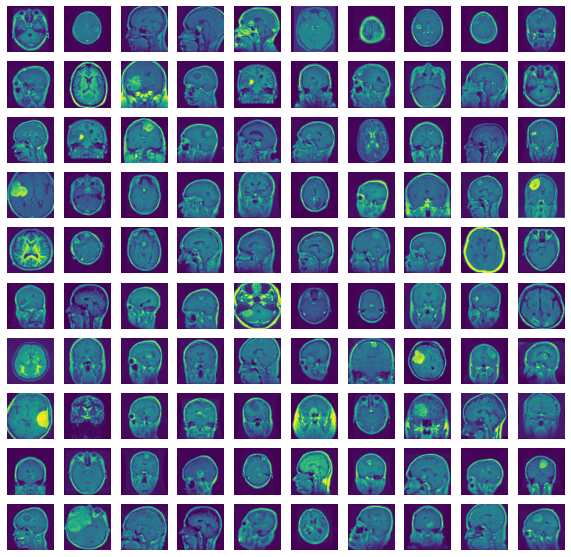

In [3]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:,:,0])
    ax.axis('off')

In [4]:
input_img = layers.Input(shape=(N, N, 1))
# encoder
# final conv2d, batch norm and spatial dropout
x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(input_img) # consider using alternate activation
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x) # consider using alternate activation
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Activation('relu')(x)

# compressed representation bottleneck
encoded = layers.MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

# neural net (dense layers) (classifier)
x = layers.Flatten()(encoded)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
class_output= layers.Dense(num_classes, activation='softmax', name='Class_output')(x)

# decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same', name='autoencoder_output')(x)

autoEncoder = keras.Model(input_img, {'ae': decoded, 'class' : class_output})

In [5]:
encoded = keras.Model(input_img,encoded)
decoder_layer = autoEncoder.layers[-1]
decoder = keras.Model(input_img, decoder_layer(input_img))

In [6]:
autoEncoder.compile(optimizer='adam', loss={'ae' : 'mean_squared_error', 'class' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)}, metrics=['accuracy'])
print(autoEncoder.summary())
keras.utils.plot_model(autoEncoder, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   18464       ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d_1[0][0]']               
 alization)                                                                                   

In [7]:
classWeights = class_weights()
history = autoEncoder.fit(x_train, {'ae' : x_train, 'class' : y_train},
                    batch_size=128,
                    epochs=100,
                    validation_data=(x_val, {'ae' : x_val, 'class' : y_val} ), 
                    verbose = False)

C:\Users\61424\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


loss
autoencoder_output_loss
Class_output_loss
autoencoder_output_accuracy
Class_output_accuracy
val_loss
val_autoencoder_output_loss
val_Class_output_loss
val_autoencoder_output_accuracy
val_Class_output_accuracy


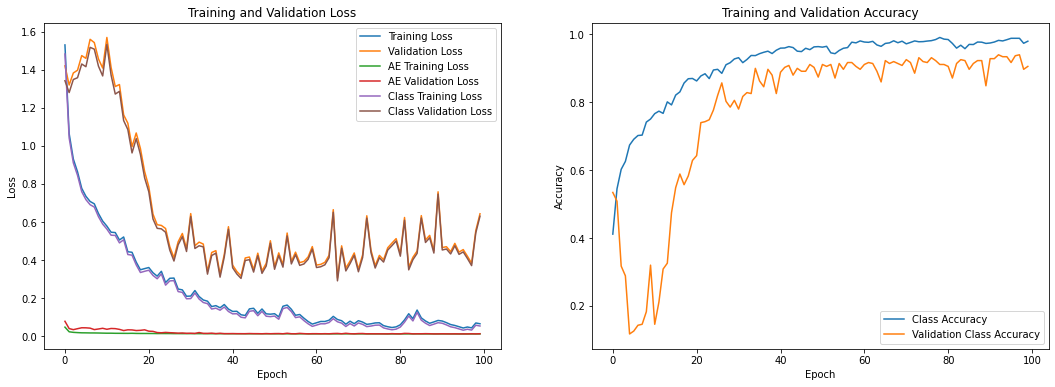

In [8]:
for value in history.history:
    print(value)

def plot_history(history):
    fig = plt.figure(figsize=[18, 6])   
    fig.add_subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.plot(history['autoencoder_output_loss'], label='AE Training Loss')
    plt.plot(history['val_autoencoder_output_loss'], label='AE Validation Loss')
    plt.plot(history['Class_output_loss'], label='Class Training Loss')
    plt.plot(history['val_Class_output_loss'], label='Class Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    fig.add_subplot(1, 2, 2)
    plt.plot(history['Class_output_accuracy'], label='Class Accuracy')
    plt.plot(history['val_Class_output_accuracy'], label='Validation Class Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plot_history(history.history)

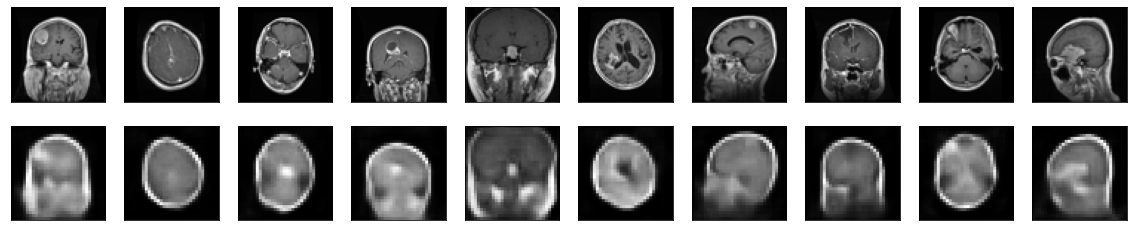

In [10]:
decoded_imgs = autoEncoder.predict(x_test)['ae']

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
bottleneck_output = autoEncoder.get_layer('bottleneck').output 
bottleneck_output = layers.Flatten()(bottleneck_output)
bottleneck_model = keras.Model(inputs = autoEncoder.input, outputs = bottleneck_output)
bottleneck_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0   

In [12]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[18, 6])

    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, ax=ax)
    pred = model.predict(X_train)
    matches = (pred == Y_train.reshape(-1))
#    matches = (pred == Y_train).numpy()
    conf.ax_.set_title('Training Set Performance: %s' % (sum(matches)/len(matches)));

    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, ax=ax)
    pred = model.predict(X_test)
    matches = (pred == Y_test.reshape(-1))
#    matches = (pred == Y_test).numpy()
    conf.ax_.set_title('Test Set Performance: %s' % (sum(matches)/len(matches)));  
    print(classification_report(Y_test, model.predict(X_test)))

(2450, 64, 64, 1)
(2450, 1024)


c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.33      0.88      0.48         8
           1       0.98      0.84      0.91       102
           2       0.95      0.95      0.95       127
           3       0.98      1.00      0.99        46

    accuracy                           0.92       283
   macro avg       0.81      0.92      0.83       283
weighted avg       0.95      0.92      0.93       283



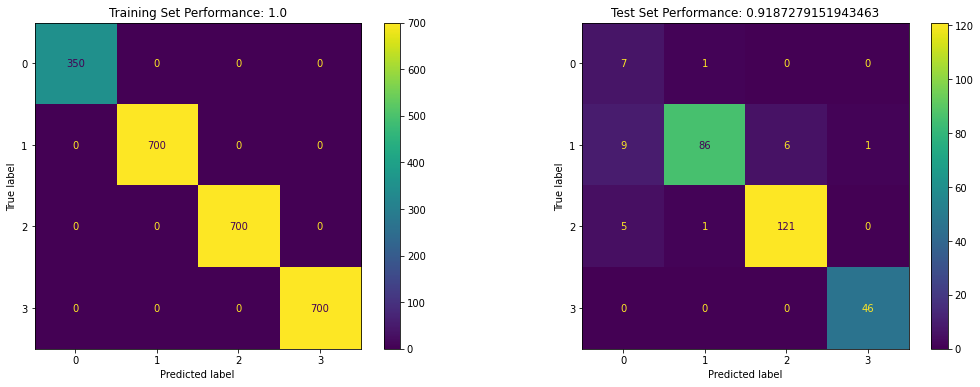

In [13]:
print(x_train.shape)
train_ae_feat = bottleneck_model.predict(x_train)
print(train_ae_feat.shape)
test_ae_feat = bottleneck_model.predict(x_test)

cknn = KNeighborsClassifier(n_neighbors=1, weights='distance').fit(train_ae_feat, y_train)
eval_model(cknn, train_ae_feat, y_train, test_ae_feat, y_test)

c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


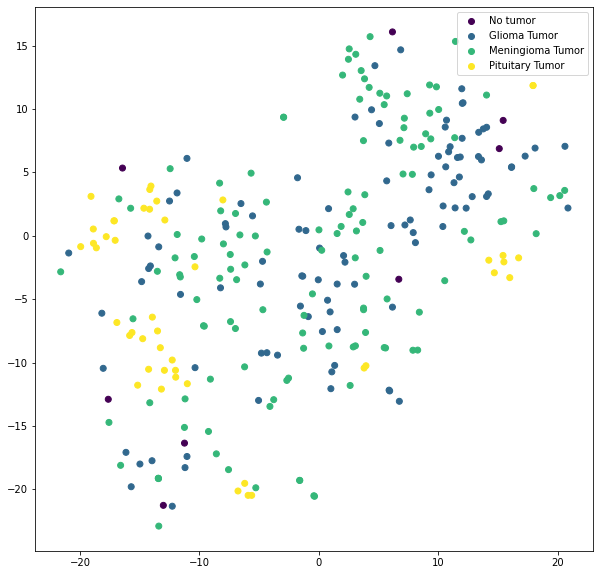

In [14]:
fig = plt.figure(figsize=[10, 10])
plt.set_cmap('viridis')
ax = fig.add_subplot(1, 1, 1)
embeddings = bottleneck_model.predict(x_test)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
labels = ['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']
scatter = ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.show()

[ 21   8  88 102 127 127  47  46]


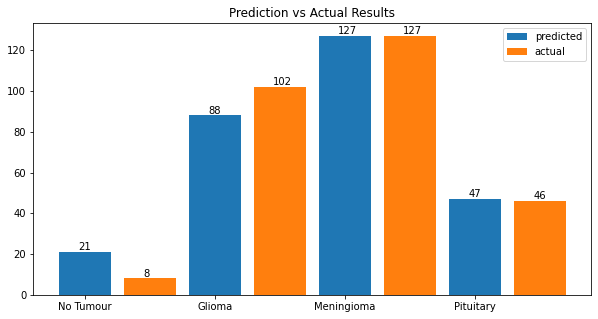

In [15]:
pred = cknn.predict(test_ae_feat);

fig = plt.figure(figsize=[10, 5])
ax = fig.subplots()

test_thing = y_test[:] + 0.5

all_counts = []
for i in range(len(pred)):
    all_counts.append(pred[i])
    all_counts.append(test_thing[i][0])

labels_all, count_all = np.unique(all_counts, return_counts=True)
print(count_all)

labels, counts = np.unique(pred, return_counts=True)
labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
ax.set_title('Prediction vs Actual Results')
plt.bar(labels, counts, align='center', width = 0.4)
plt.gca().set_xticks(labels)
test_thing = y_test[:] + 0.5
labels, counts = np.unique(test_thing, return_counts=True)
plt.bar(labels, counts, align='center', width = 0.4)
ax.legend(['predicted', 'actual'])

x = [0,0.5,1,1.5,2,2.5,3,3.5]

for i in range(len(count_all)):
    ax.text(x[i]-0.05, count_all[i] + 1, str(count_all[i]))
    
plt.show()

